Se importan las siguiente librerías:
- pandas: para poder cargar el dataset
- numpy: para poder manipular los arreglos y usar vectorización
- matplotlib: para graficar
- sklearn: para poder usar el label encoding, estandarizar, one-hot encoding y calcular las métricas

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

Se cargan los datos del dataset.

In [15]:
df = pd.read_csv('heart.csv')
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


Función para dividir el datasaet en subconjuntos.

In [16]:
def validate(partitions: tuple[int, ...], X = np.array, Y = np.array):
  assert type(partitions) == tuple, 'Partitions must be a tuple of ints'
  assert sum(partitions) == 100, 'Sum of paritions must be 100'
  assert type(X) == np.ndarray, 'X must be a NDArray'
  assert type(Y) == np.ndarray, 'X must be a NDArray'
  assert X.shape[0] == Y.shape[0], f'X and Y must have the same dimension'

def split_sequencial (partitions: tuple[int, ...], X = np.array, Y = np.array):
  validate(partitions, X, Y)

  length = X.shape[0]
  start_index = 0
  for partition in partitions:
    step = round(partition / 100 * length)
    end_index = start_index + step
    yield X[start_index:end_index]
    yield Y[start_index:end_index]
    start_index = end_index
    start_index = end_index

Se obtienen las X de forma individual y después se apilan en una sola matriz la cuál se estandariza. Finalmente el conjunto se divide en subconjuntos de entrenamiento y prueba.

In [17]:
X1 = df['age'].values
X2 = df['sex'].values
X3 = df['cp'].values
X4 = df['trtbps'].values
X5 = df['chol'].values
X6 = df['fbs'].values
X7 = df['restecg'].values
X8 = df['thalachh'].values
X9 = df['exng'].values
X10 = df['oldpeak'].values
X11 = df['slp'].values
X12 = df['caa'].values
X13 = df['thall'].values
Y = df['output'].values
X = np.column_stack((X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13))
ss = StandardScaler()
X = ss.fit_transform(X)
X_train, Y_train, X_test, Y_test = split_sequencial((80, 20), X, Y)

Se define la clase para el Perceptron multicapa multiclase junto a las funciones que este necesita como la función sigmoide, la función softmax, la propagación frontal y la de retroceso.

In [18]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

def softmax(z):
    exp_values = np.exp(z - np.max(z, axis=0, keepdims=True))
    return exp_values / np.sum(exp_values, axis=0, keepdims=True)

def forward_propagation(w1, w2, x):
    z1 = np.dot(w1, x)
    a1 = sigmoid(z1)
    z2 = np.dot(w2, a1)
    a2 = softmax(z2)
    return z1, a1, z2, a2

def back_propagation(m, w1, w2, z1, a1, z2, a2, y, x):
    dz2 = a2 - y.T
    dw2 = np.dot(dz2, a1.T) / m
    dz1 = np.dot(w2.T, dz2) * a1 * (1 - a1)
    dw1 = np.dot(dz1, x.T) / m
    dw1 = np.reshape(dw1, w1.shape)
    dw2 = np.reshape(dw2, w2.shape)
    return dz2, dw2, dz1, dw1

def categorical_cross_entropy(yreal, ypred):
    return -np.sum(yreal.T * np.log(ypred + 1e-8))

class MLP:
    def __init__(self, n_i=2, n_o=7, n_h=2, lr=0.1, iters=10000):
        self.n_x = n_i
        self.n_y = n_o
        self.n_h = n_h
        self.w1, self.w2 = None, None
        self.iters = iters
        self.losses = []
        self.lr = lr

    def init_weights(self):
        self.w1 = np.random.rand(self.n_x, self.n_h)
        self.w2 = np.random.rand(self.n_y, self.n_h)

    def fit(self, x, y):
        y = OneHotEncoder(sparse_output=False).fit_transform(y.reshape(-1, 1))
        m = x.shape[1]
        self.init_weights()
        for i in range(self.iters):
            z1, a1, z2, a2 = forward_propagation(self.w1, self.w2, x)
            loss = (1 / m) * categorical_cross_entropy(y, a2)
            self.losses.append(loss)
            dz2, dw2, dz1, dw1 = back_propagation(m, self.w1, self.w2, z1, a1, z2, a2, y, x)
            self.w2 = self.w2 - self.lr * dw2
            self.w1 = self.w1 - self.lr * dw1
        return self

    def predict(self, input):
        z1, a1, z2, a2 = forward_propagation(self.w1, self.w2, input)
        return np.argmax(a2, axis=0)

Se entrenan 5 modelos a la vez y se busca el modelo con mayor puntaje con la función `accuracy_score`.

In [27]:
%%time
model = max(
    [MLP(13, 2, 13, 0.1, 16000) for i in range(0, 5)],
    key=lambda model: accuracy_score(Y_train, model.fit(X_train.T, Y_train).predict(X_train.T))
)

CPU times: user 4.18 s, sys: 21 ms, total: 4.21 s
Wall time: 4.21 s


Se realiza la predicción de los datos de prueba y se obtiene los puntajes con las funciones:
- `accuracy_score`
- `precision_score`
- `f1_score`
- `recall_score` (Sensitivity)

In [24]:
predictions = model.predict(X_test.T)
print(f'Accuracy score with test dataset: {accuracy_score(Y_test, predictions)}')
print(f'Precision score (Macro) with test dataset: {precision_score(Y_test, predictions, average="macro")}')
print(f'Precision score (Micro) with test dataset: {precision_score(Y_test, predictions, average="micro")}')
print(f'Precision score (Weighted) with test dataset: {precision_score(Y_test, predictions, average="weighted")}')
print(f'F1 score (Macro) with test dataset: {f1_score(Y_test, predictions, average="macro")}')
print(f'F1 score (Micro) with test dataset: {f1_score(Y_test, predictions, average="micro")}')
print(f'F1 score (Weighted) with test dataset: {f1_score(Y_test, predictions, average="weighted")}')
print(f'Sensitivity score (Macro) with test dataset: {recall_score(Y_test, predictions, average="macro", zero_division=0)}')
print(f'Sensitivity score (Micro) with test dataset: {recall_score(Y_test, predictions, average="micro", zero_division=0)}')
print(f'Sensitivity score (Weighted) with test dataset: {recall_score(Y_test, predictions, average="weighted", zero_division=0)}')

Accuracy score with test dataset: 0.6557377049180327
Precision score (Macro) with test dataset: 0.5
Precision score (Micro) with test dataset: 0.6557377049180327
Precision score (Weighted) with test dataset: 1.0
F1 score (Macro) with test dataset: 0.39603960396039606
F1 score (Micro) with test dataset: 0.6557377049180327
F1 score (Weighted) with test dataset: 0.7920792079207921
Sensitivity score (Macro) with test dataset: 0.32786885245901637
Sensitivity score (Micro) with test dataset: 0.6557377049180327
Sensitivity score (Weighted) with test dataset: 0.6557377049180327


Se gráfica la perdida conforme a las iteraciones.

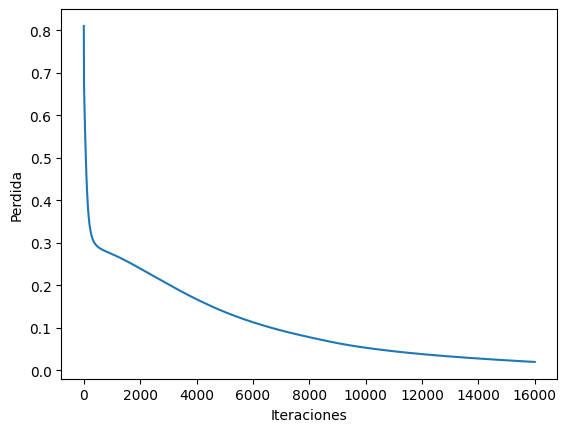

In [20]:
plt.plot(model.losses)
plt.xlabel("Iteraciones")
plt.ylabel("Perdida")
plt.savefig('./MLP-employee-loss.png')
plt.show()